In [102]:
from ConfigDataset import ConfigDataset
from DataLoader import DataLoader
from EmbeddedRegions import EmbeddedRegions

In [103]:
chroms = ['X'] 

In [104]:
config_ds = ConfigDataset(
    '../../../data/processed_data.hdf5',
    segment_length=64,
    batch_size=0,
    normalize_distances=True,
    geos=None,
    organisms=None,
    cell_types=None,
    cell_numbers=None,
    chroms=chroms,
    replicates=None,
    shuffle=True,
    allow_overlap=False,
    two_channels=False,
    try_GPU=True,
    mean_dist_fp='../../../data/mean_dists.pt',
    mean_sq_dist_fp='../../../data/squares.pt'
)

In [105]:
er = EmbeddedRegions(
    '../../../data/embeddings/',
    chroms=chroms
)

In [106]:
dl = DataLoader(
    config_ds,
    er,
    drop_unmatched_pairs=True, # Should we drop the unneeded rows in the embedder object?
    shuffle = True,
    batch_size=64
)

In [107]:
dist_maps, embeddings = next(dl)

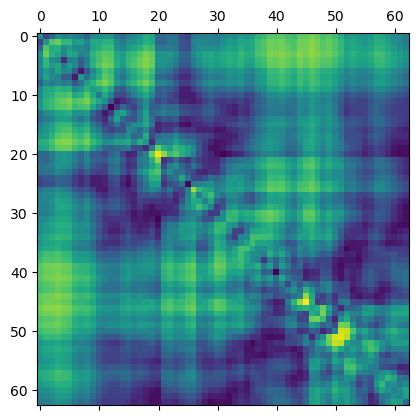

In [17]:
import matplotlib.pyplot as plt

lineage = 0
sample =  0

plt.matshow(dist_maps[sample,lineage,...].numpy())

In [9]:
dl.index['Chromosome'].unique().tolist()

['X']

In [19]:
tuple(er.ifetch(0)[0].shape)

(1, 260, 256)

In [20]:
tuple(config_ds.fetch(0)[0].shape)

(2, 63, 63)

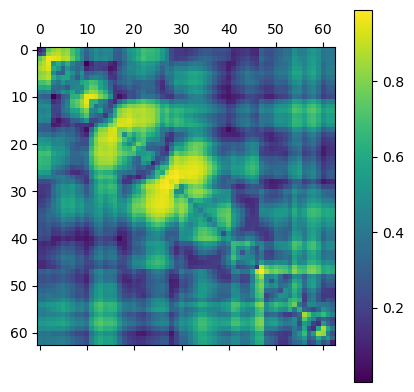

<Figure size 640x480 with 0 Axes>

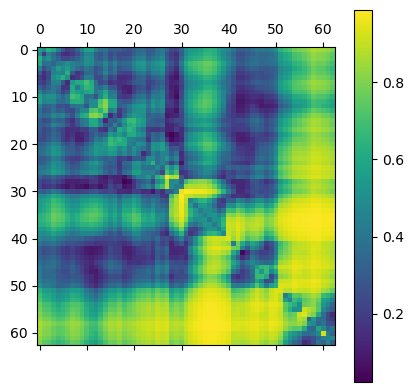

In [23]:
a = config_ds.fetch(0)[0]
plt.matshow(a[0,...].numpy())
plt.colorbar()
plt.figure()
plt.matshow(a[1,...].numpy())
plt.colorbar()

In [2]:
import torch
from torch import nn

In [56]:
def numel(sequential):

    numel = torch.zeros(len(classes_mlp))
    for i,l in enumerate(classes_mlp):
        for p in l.parameters():
            numel[i]+= p.numel()
    return numel

In [71]:
class Flatten(torch.nn.Module):
    def forward(self, x):
        batch_size = x.shape[0]
        return x.view(batch_size, -1)

In [72]:
c = 1
s = 256
classes_mlp = nn.Sequential( # (1,260,256) -> 2x256x256
    nn.Conv2d(in_channels=c,out_channels=2*c,kernel_size=7,stride=1, padding=(1,3)), 
    nn.GELU()
)

c*= 2 # update # channels
for k in range(4): # Overall change: (2,256,256) -> (32,16,16)
    
    # Lengthen, mix data
    classes_mlp.append( # (C,H,W) -> (2*C,H,W)
        nn.Conv2d(c,2*c,kernel_size=3,stride=1, padding=2)
    )
    classes_mlp.append(nn.GELU())
    c*= 2 

    # Mix again without lengthening 
    classes_mlp.append( # (2*C,H,W) -> (2*C,H,W)
        nn.Conv2d(c,c,kernel_size=3,stride=1, padding=2) 
    )

    # Pool to decrease data size 
    classes_mlp.append( # (2*C,H,W) -> (2*C,H/2,W/2) 
        nn.AdaptiveMaxPool2d((s//2,s//2)) 
    )
    s//=2 

    classes_mlp.append(nn.GELU()) # Activation

classes_mlp.append(Flatten())
classes_mlp.append(
    nn.Linear(c*s**2,4*64)
);

In [73]:
data = torch.rand(2,1,260,256)
out = classes_mlp(data)
out.shape

torch.Size([2, 256])

In [74]:
ne = numel(classes_mlp) 
ne.sum()

tensor(2115988.)

In [75]:
(256 * 256 * 256) * 4 / 1028**3

0.06177326313508666

In [76]:
32*16*16


8192

In [86]:
import math
import copy
from pathlib import Path
from random import random
from functools import partial
from collections import namedtuple
from multiprocessing import cpu_count

import torch
from torch import nn, einsum
import torch.nn.functional as F
from torch.cuda.amp import autocast

from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange

from tqdm.auto import tqdm

# For the Trainer class
from accelerate import Accelerator
from torch.optim import Adam
from ema_pytorch import EMA
import sys
sys.path.insert(1,'../../diffusion/')
from fid_evaluation import FIDEvaluation # relative import

In [89]:
a = (1,260,256)
torch.randn(a).shape

torch.Size([1, 260, 256])

In [100]:
def prob_mask_like(shape, prob, device):
    if prob == 1:
        return torch.ones(shape, device = device, dtype = torch.bool)
    elif prob == 0:
        return torch.zeros(shape, device = device, dtype = torch.bool)
    else:
        return torch.zeros(shape, device = device).float().uniform_(0, 1) < prob


classes_emb = torch.randn(64,1,260,256)
null_classes_emb = torch.randn(64,1,260,256)
cond_drop_prob = .5
batch = classes_emb.shape[0]
device = 'cpu'

keep_mask = prob_mask_like((batch,), 1 - cond_drop_prob, device = device)

classes_emb = torch.where(
    rearrange(keep_mask, 'b -> b 1 1 1'),
    classes_emb,
    null_classes_emb
)


In [99]:
rearrange(keep_mask, 'b -> b 1 1 1').shape

torch.Size([64, 1, 1, 1])

In [108]:
tuple(er.ifetch(0)[0].shape)

(1, 260, 256)

In [126]:
tuple(config_ds.fetch((1,'mat')).shape)

(1, 1, 63, 63)

In [111]:
a = next(dl) 

In [112]:
a[0].shape

torch.Size([64, 1, 63, 63])

In [113]:
a[1].shape

torch.Size([64, 1, 260, 256])

In [127]:
torch.rand(1,2,3).expand(5,-1,-1)

tensor([[[0.2289, 0.2740, 0.8361],
         [0.2773, 0.0590, 0.0355]],

        [[0.2289, 0.2740, 0.8361],
         [0.2773, 0.0590, 0.0355]],

        [[0.2289, 0.2740, 0.8361],
         [0.2773, 0.0590, 0.0355]],

        [[0.2289, 0.2740, 0.8361],
         [0.2773, 0.0590, 0.0355]],

        [[0.2289, 0.2740, 0.8361],
         [0.2773, 0.0590, 0.0355]]])